In [116]:
# =============================================================================
# Created By:     Kai Metzger
# Created School: Franz-Oberthuer-Schule Wuerzburg
# Created Email:  metzgerkai@franz-oberthuer-schule.de
# Created Date:   Fri December 06 18:08 UTC 2024
# Version:        1.0
# =============================================================================
"""The Module has been build for training the symbols dataset with images + 
ground truth on a Raspberry Pi 5 with a standard USB camera. An image with a 
resolution of 640px x 480px can be recorded with the Python script 
create-symbols-dataset.py.
The files in the dataset <2023 symbols> should be ordered in the following
manner:             > explanation
- 2023 symbols      
  - dataset3        > dataset version (dataset1 - 3 where used in the project)
    - data          > images (.png files)
    - gt            > ground truth (.txt files with class labels 1-4)
"""

# =============================================================================
# Import
# =============================================================================
import cv2
import os
import numpy as np
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt

# To get reproducable results with the same training setting random seed
SEED = 42
np.random.seed(SEED)

In [117]:
# =============================================================================
# Declare variables
# =============================================================================
img_size_x = 32
img_size_y = 24
img_dim = img_size_x * img_size_y

# Change the following paths to your dataset path
img_dir = '/home/pi/Documents/ml-project/2023 symbols/dataset1/data'
gt_dir = '/home/pi/Documents/ml-project/2023 symbols/dataset1/gt'
checkpoint_filepath = '/home/pi/Documents/ml-project/2023 symbols/dataset1/chpt/'

In [118]:
# =============================================================================
# Get number of data (image/label) 
# =============================================================================
anz_data = len(os.listdir(img_dir))
anz_data = int(anz_data) - 1
dataset = np.zeros((anz_data, img_size_x, img_size_y), dtype=float)
ground_truth = np.zeros((anz_data), dtype=int)
print("dataset size:", anz_data)

dataset size: 176


In [119]:
# =============================================================================
# Define functions
# =============================================================================
# Change image size and convert to grayscale images
def pic_prep (image, x, y):
  image = cv2.resize(image, (y,x))                # change image size
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
  image = image / 255                             # image normalization
  return image

# Shuffle images
def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


In [120]:
# =============================================================================
# Callback for training
# =============================================================================
# Set verbose flag to 0 to omit loss/accuracy output per epoch
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + "chpt.keras",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True,
    verbose = 1)

In [121]:
# =============================================================================
# Read dataset
# =============================================================================
for i in range(0, anz_data, 1):
    img_name = img_dir + '/' + str(i) + '.png'      # create file names
    image = cv2.imread(img_name)                    # read image
    image = pic_prep(image, img_size_x, img_size_y) # prepare image
    dataset[i,:,:] = image                          # 2d-image to 3d-array
    
    txt_name = gt_dir + '/' + str(i) + '.txt'       # create gt file names
    ground_truth[i] = np.genfromtxt(txt_name, delimiter=',') 

In [122]:
# =============================================================================
# Prepare dataset: train set (80%) and test set (20%)
# =============================================================================
dataset = dataset.reshape(anz_data, img_dim) # convert into 2d array (all pixel in one row)
ground_truth = ground_truth.reshape(anz_data, 1)

dataset, ground_truth = unison_shuffle(dataset, ground_truth)

trainset = np.random.choice(dataset.shape[0],
                            int(dataset.shape[0]*0.80), 
                            replace=False)
train_data = dataset[trainset,:]
train_gt = ground_truth[trainset]
train_gt = utils.to_categorical(train_gt, 4)

testset = np.delete(np.arange(0, len(ground_truth) ), 
                    trainset) 
test_data = dataset[testset,:]
test_gt = ground_truth[testset]
test_gt = utils.to_categorical(test_gt, 4)

#print(ground_truth)
#print(dataset)
#print(trainset)
#print(train_data)
#print(train_gt)

In [123]:
# =============================================================================
# Create neural network with 4 layers and (64, 32, 16, 4) neurons per layer.
# =============================================================================
model = models.Sequential()
model.add(layers.Dense(64,input_dim=img_dim,activation='relu'))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(4,activation='sigmoid'))
model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=['accuracy'])


In [124]:
# =============================================================================
# Train the neuronal network e.g. for 300 epochs.
# =============================================================================
history = model.fit(train_data, 
                    train_gt, 
                    batch_size=4, 
                    epochs=300, 
                    verbose=0, 
                    shuffle=True, 
                    validation_data=(test_data, test_gt), 
                    callbacks=[model_checkpoint_callback])


Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /home/pi/Documents/ml-project/2023 symbols/dataset1/chpt/chpt.keras

Epoch 2: val_accuracy did not improve from 0.25000

Epoch 3: val_accuracy did not improve from 0.25000

Epoch 4: val_accuracy did not improve from 0.25000

Epoch 5: val_accuracy did not improve from 0.25000

Epoch 6: val_accuracy did not improve from 0.25000

Epoch 7: val_accuracy did not improve from 0.25000

Epoch 8: val_accuracy did not improve from 0.25000

Epoch 9: val_accuracy did not improve from 0.25000

Epoch 10: val_accuracy did not improve from 0.25000

Epoch 11: val_accuracy did not improve from 0.25000

Epoch 12: val_accuracy did not improve from 0.25000

Epoch 13: val_accuracy did not improve from 0.25000

Epoch 14: val_accuracy did not improve from 0.25000

Epoch 15: val_accuracy did not improve from 0.25000

Epoch 16: val_accuracy did not improve from 0.25000

Epoch 17: val_accuracy did not improve from 0.25000

Epoch 18: val_accurac

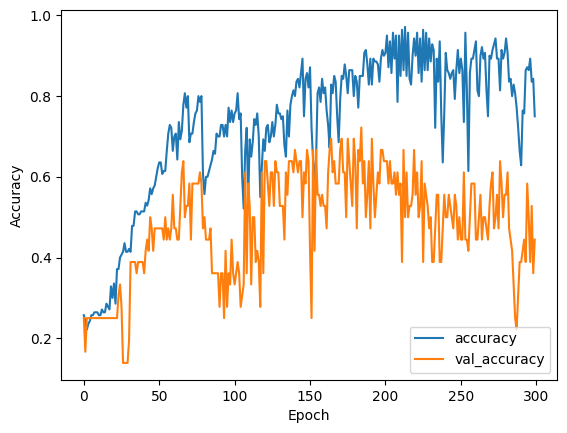

In [125]:
# =============================================================================
# Plot train and val accuracy.
# =============================================================================

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


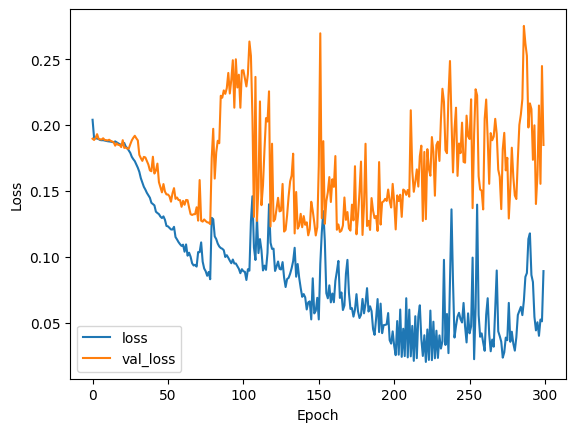

In [126]:
# =============================================================================
# Plot train and val loss.
# =============================================================================

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.show()

In [127]:
# =============================================================================
# Load pretrained dataset weights to e.g. test on new (unseen) data.
# =============================================================================
model.load_weights(checkpoint_filepath + "chpt.keras")

In [128]:
# =============================================================================
# Test dataset on xxx.
# =============================================================================
score = model.evaluate(test_data, test_gt, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7106 - loss: 0.1228 
Test score: 0.12044073641300201
Test accuracy: 0.7222222089767456


In [129]:
# =============================================================================
# Testing on a single image.
# =============================================================================
data_pred = np.zeros((1, img_size_x, img_size_y), dtype=float)
img_pred = cv2.imread('/home/pi/Documents/ml-project/2023 symbols/dataset3/data/14.png')
img_pred = pic_prep(img_pred, img_size_x, img_size_y)
data_pred[0,:,:] = img_pred
data_pred = data_pred.reshape(1,img_dim)
result = model.predict(data_pred)
result = np.round(result, decimals=2)

print("Probability for classes: (cross, circle, triangle, square) in percent", 
      result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Probability for classes: (cross, circle, triangle, square) in percent [[0.47 0.01 0.51 0.  ]]


In [130]:
# =============================================================================
# Output class: 
# translate class label (0,1,2,3) to class (cross, circle, triangle, square).
# =============================================================================

max_res = 0
res_index = 4
for i in range(0, 4, 1):
    if result[0,i] > max_res:
        max_res = result[0,i]
        res_index = i

if res_index == 0:
    print('Cross detected!')
elif res_index == 1:
    print('Circle detected!')
elif res_index == 2:
    print('Triangle detected!')
elif res_index == 3:
    print('Square detected!')
elif res_index == 4:
    print('Error!')

Triangle detected!
